In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

(281, 180, 3)


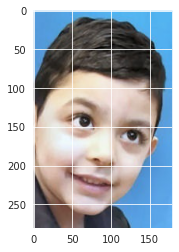

In [3]:
fpath = "/content/drive/MyDrive/AutismDataset/test/Autistic.0.jpg"
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

In [4]:
filenames = os.listdir("/content/drive/MyDrive/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
train_df.head()


,filename,category
0,Non_Autistic.1217.jpg,0
1,Non_Autistic.1030.jpg,0
2,Non_Autistic.180.jpg,0
3,Non_Autistic.119.jpg,0
4,Autistic.914.jpg,1


In [6]:
train_df.tail()

,filename,category
2545,Autistic.202.jpg,1
2546,Autistic.433.jpg,1
2547,Autistic.40.jpg,1
2548,Autistic.290.jpg,1
2549,Autistic.539.jpg,1


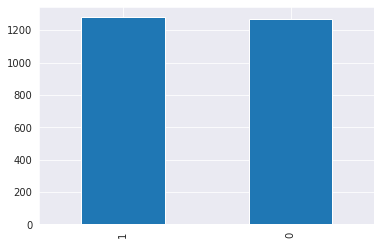

In [7]:
train_df['category'].value_counts().plot.bar()

In [8]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [9]:
test_df.head()


,filename,category
0,Autistic.42.jpg,1
1,Autistic.148.jpg,1
2,Autistic.51.jpg,1
3,Autistic.106.jpg,1
4,Autistic.56.jpg,1


In [10]:
test_df.tail()

,filename,category
295,Non_Autistic.53.jpg,0
296,Non_Autistic.73.jpg,0
297,Autistic.91.jpg,1
298,Non_Autistic.47.jpg,0
299,Non_Autistic.144.jpg,0


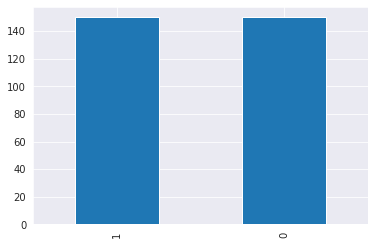

In [11]:
test_df['category'].value_counts().plot.bar()

In [12]:
valid_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/valid")
categories = []
for filename in valid_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

valid_df = pd.DataFrame({
    'filename': valid_filenames,
    'category': categories
})

In [13]:
valid_df.head()

,filename,category
0,Non_Autistic. (9).jpg,0
1,Autistic. (19).jpg,1
2,Autistic. (7).jpg,1
3,Autistic. (38).jpg,1
4,Non_Autistic. (4).jpg,0


In [14]:
valid_df.tail()

,filename,category
95,Non_Autistic. (30).jpg,0
96,Non_Autistic. (37).jpg,0
97,Non_Autistic. (50).jpg,0
98,Non_Autistic. (49).jpg,0
99,Non_Autistic. (33).jpg,0


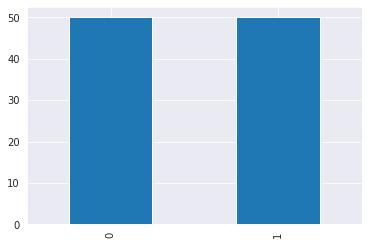

In [15]:
valid_df['category'].value_counts().plot.bar()

In [16]:
height=254
width=254
channels=3
batch_size=64
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  75   test steps:  4


In [17]:
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)

In [18]:
print('for the train generator')
train_gen=gen.flow_from_dataframe(train_df,"/content/drive/MyDrive/AutismDataset/train",
                                 x_col='filename', y_col='category',class_mode='categorical',color_mode='rgb', target_size=img_size,shuffle=True, batch_size=batch_size)
print('for the test generator')
test_gen=gen.flow_from_dataframe(test_df,"/content/drive/MyDrive/AutismDataset/test",
                                 x_col='filename', y_col='category',class_mode='categorical',color_mode='rgb', target_size=img_size,shuffle=False, batch_size=batch_size)
print('for the validation generator')
valid_gen=gen.flow_from_dataframe(valid_df,"/content/drive/MyDrive/AutismDataset/valid",
                                 x_col='filename', y_col='category',class_mode='categorical',color_mode='rgb', target_size=img_size,shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

for the train generator
Found 2550 validated image filenames belonging to 2 classes.
for the test generator
Found 300 validated image filenames belonging to 2 classes.
for the validation generator
Found 100 validated image filenames belonging to 2 classes.


In [19]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

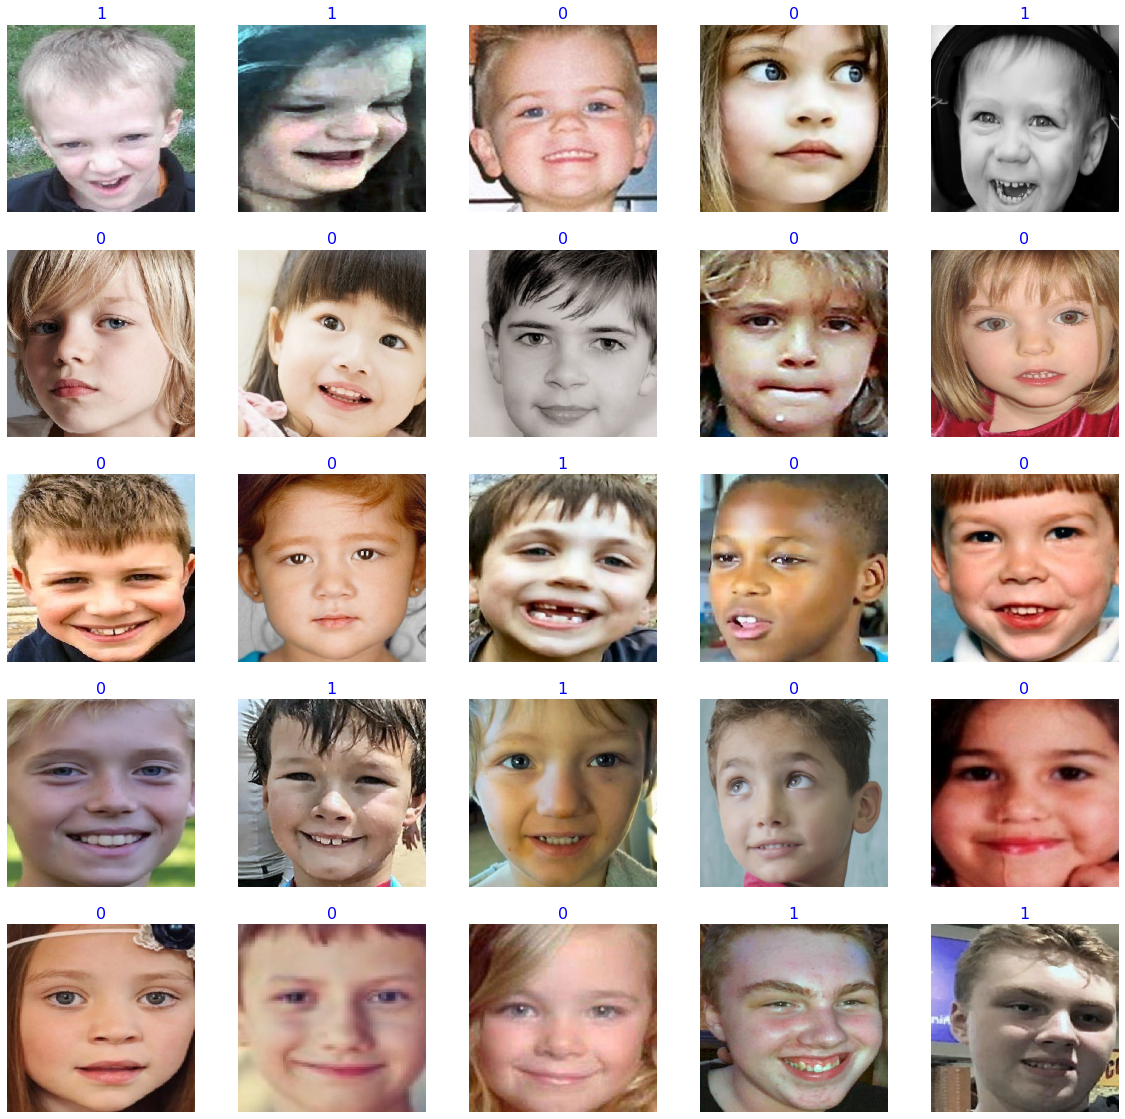

In [20]:
show_image_samples(train_gen)

In [21]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [22]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=False
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [23]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [24]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        msg='setting base_model as trainable for fine tuning of model'
                        self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

In [25]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
ask_epoch = 5
batches=int(len(train_gen.labels)/batch_size)
callbacks=[LRA(model=model, base_model=base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

initializing callback starting training with base_model not trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     7.487   66.745   6.66621  69.000   0.00100  0.00100  accuracy   68.20  

 2 /40     5.689   77.255   5.24152  73.000   0.00100  0.00100  accuracy   40.36  

 3 /40     4.655   80.392   4.35589  71.000   0.00100  0.00100  accuracy   40.33  

 4 /40     3.932   82.078   3.74071  71.000   0.00100  0.00100  accuracy   40.27  

 5 /40     3.358   84.863   3.26180  70.000   0.00100  0.00100  accuracy   40.23  

enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again

 training will continue until epoch 40

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 6 /40     2.910   86.471   2.89468  75.000   0.00100  0.00100  accuracy   40.50  

 7 /40     2.541   88.235   2.55511  71.000   0.00100  0.00100  accuracy   40.36  

 8 /40     2.227   89.686   2.28744  7

In [26]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [27]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

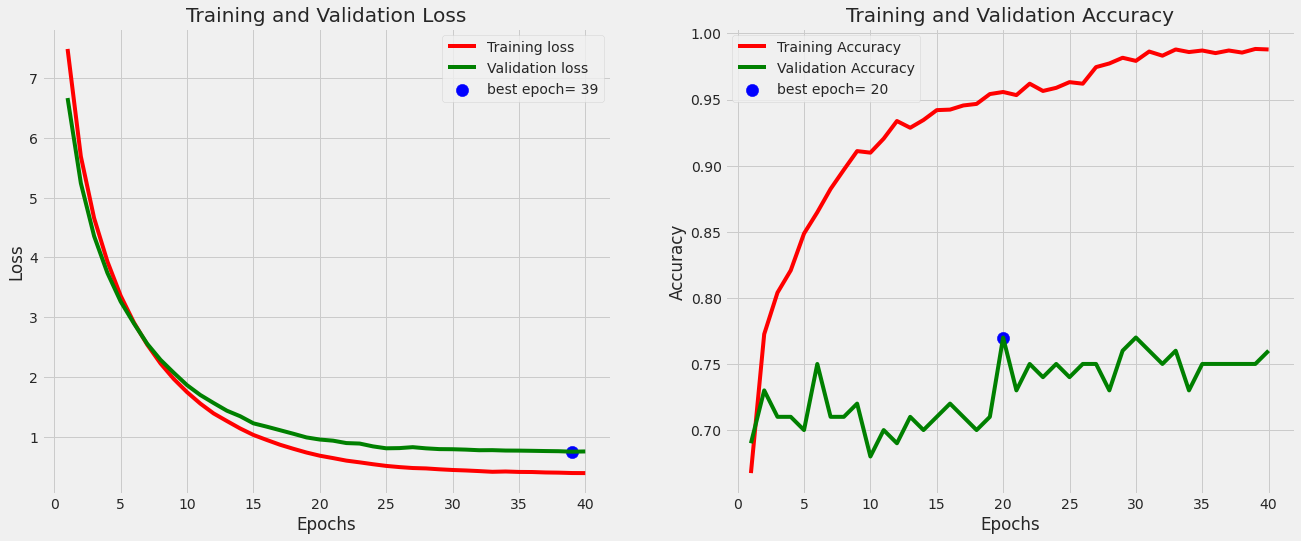

4/4 [==============================] - 55s 18s/step - loss: 0.7293 - accuracy: 0.7969
accuracy on the test set is 79.69 %



In [28]:
tr_plot(history,0)
save_dir=r'./'
subject='Autism'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [29]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [32]:
loss, accuracy = model.evaluate_generator(test_gen, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.802083  ;  loss = 0.734552 


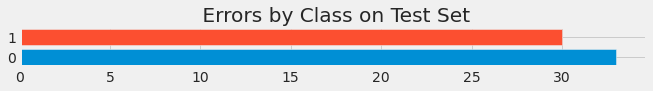

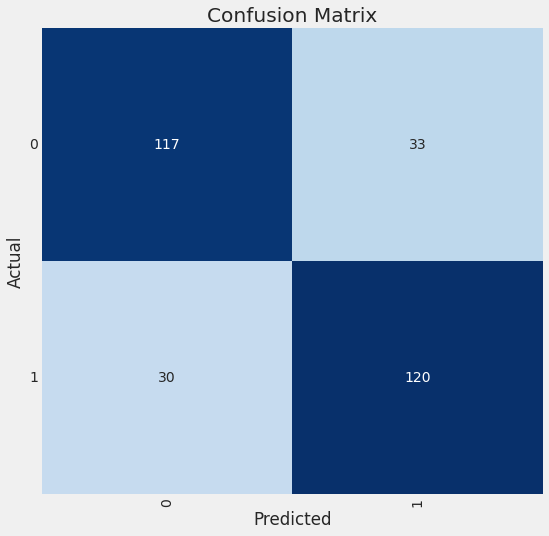

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       150
           1       0.78      0.80      0.79       150

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



In [33]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [34]:
test_filenames2 = os.listdir("/content/drive/MyDrive/Predictions")
test_df2 = pd.DataFrame({
    'filename': test_filenames2
})
nb_samples = test_df2.shape[0]

In [35]:
test_gen2=gen.flow_from_dataframe(test_df2,"/content/drive/MyDrive/Predictions",
                                 x_col='filename', y_col=None,class_mode=None,color_mode='rgb', target_size=img_size,shuffle=False, batch_size=batch_size)

Found 21 validated image filenames.


In [1]:
preds=model.predict(test_gen2) 
preds

NameError: ignored

In [37]:
test_df2['category'] = np.argmax(preds, axis=-1)
test_df2['category']

0     1
1     0
2     0
3     0
4     1
5     0
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    0
18    1
19    1
20    1
Name: category, dtype: int64

In [38]:
label_map = dict((v,k) for k,v in train_gen.class_indices.items())
test_df2['category'] = test_df2['category'].replace(label_map)
test_df2['category']

0     1
1     0
2     0
3     0
4     1
5     0
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    0
18    1
19    1
20    1
Name: category, dtype: object

In [41]:
model.save('InceptionResNetV2.h5')

ValueError: ignored